##### Required library import

In [14]:
import numpy as np
import pandas as pd
from PIL import Image
import time
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, load_iris, fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import adjusted_rand_score

#### Question 1

In [15]:
def fuzzy_c_means(X, c, m=2.0, max_iter=100, tol=1e-5):
    np.random.seed(42)
    N, _ = X.shape
    U = np.random.rand(N, c)
    U /= np.sum(U, axis=1, keepdims=True)
    for n in range(max_iter):
        U_old = U.copy()
        um = U ** m
        V = (um.T @ X) / np.sum(um.T, axis=1, keepdims=True)
        dist = np.zeros((N, c))
        for j in range(c):
            dist[:, j] = np.linalg.norm(X - V[j], axis=1)
        dist = np.fmax(dist, np.finfo(np.float64).eps)
        exponent = 2.0/(m-1)
        for i in range(N):
            for j in range(c):
                U[i, j] = 1.0 / np.sum((dist[i, j] / dist[i, :]) ** exponent)
        
        if np.max(np.abs(U - U_old)) < tol:
            break
    
    objective = np.sum((U ** m) * (dist ** 2))
    return V, U, n + 1, objective

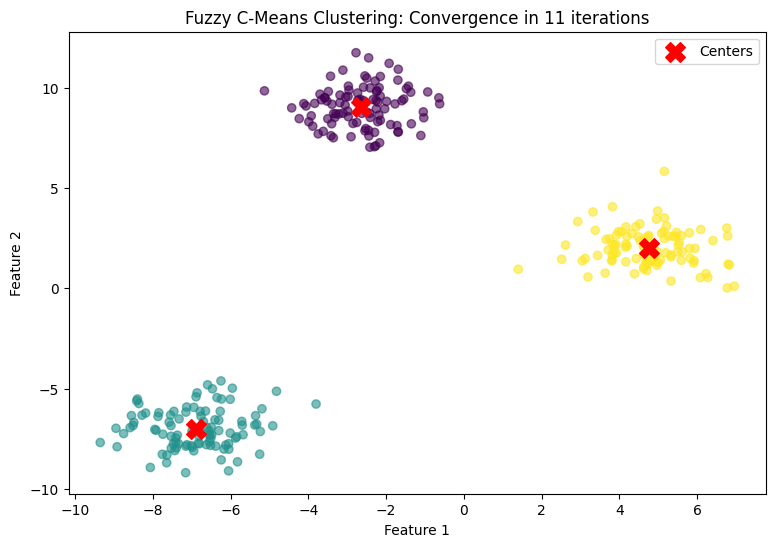

In [16]:
X, _ = make_blobs(n_samples=300, centers=3, cluster_std=1.0, random_state=42)

centers, U, n_iter, _ = fuzzy_c_means(X, c=3, m=2.0, max_iter=100, tol=1e-5)

labels = np.argmax(U, axis=1)

plt.figure(figsize=(9, 6))
scatter = plt.scatter(X[:,0], X[:,1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Centers')
plt.title(f'Fuzzy C-Means Clustering: Convergence in {n_iter} iterations')
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

#### Question 2

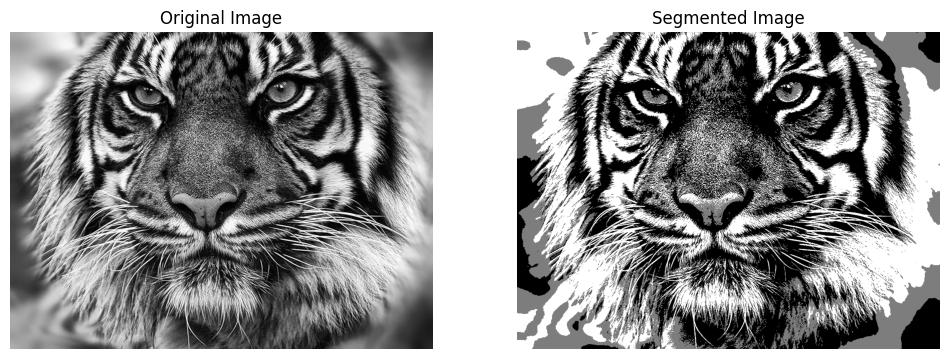

Runtime: 206.2709 seconds
Mean Squared Error: 99.3896


In [17]:
path = r'/Users/smoked_cat/Desktop/grayscale.jpg'
img = Image.open(path).convert('L')
I = np.array(img)
X = I.flatten().astype(np.float64).reshape(-1, 1)

start_time = time.time()
centers, U, iterations, _ = fuzzy_c_means(X, c=3, m=2.0, max_iter=100, tol=1e-5)
runtime = time.time() - start_time
labels = np.argmax(U, axis=1)
seg_flat = centers[labels].flatten()
segmented = seg_flat.reshape(I.shape).astype(np.uint8)
mse = np.mean((I-segmented)**2)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(I, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(segmented, cmap='gray')
axes[1].set_title('Segmented Image')
axes[1].axis('off')
plt.show()
print(f"Runtime: {runtime:.4f} seconds")
print(f"Mean Squared Error: {mse:.4f}")

#### Question 3

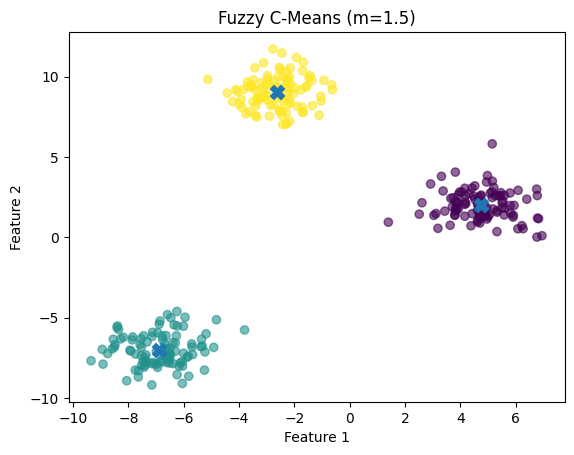

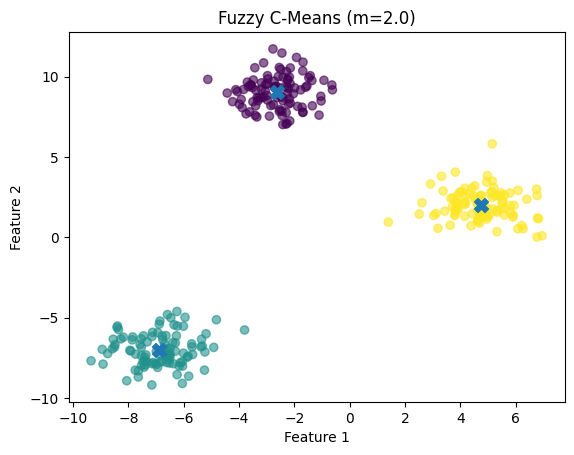

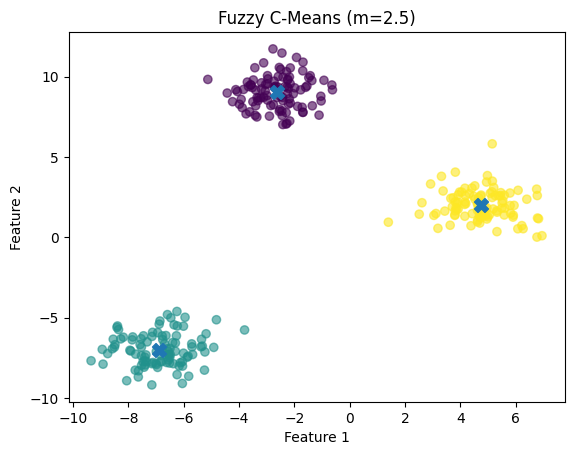

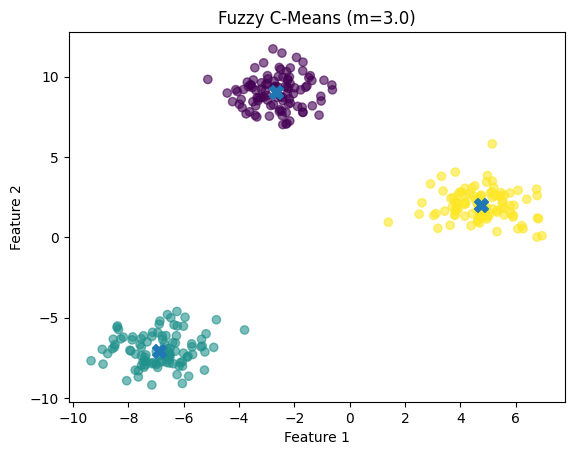

,m,iterations,objective
0,1.5,8,565.973438
1,2.0,11,540.763021
2,2.5,13,461.799193
3,3.0,16,353.615646


In [18]:
X, _ = make_blobs(n_samples=300, centers=3, cluster_std=1.0, random_state=42)

results = []
for m in [1.5, 2.0, 2.5, 3.0]:
    centers, U, iters, obj = fuzzy_c_means(X, c=3, m=m)
    labels = np.argmax(U, axis=1)
    results.append({'m': m, 'iterations': iters, 'objective': obj})
    
    plt.figure()
    plt.scatter(X[:,0], X[:,1], c=labels, alpha=0.6)
    plt.scatter(centers[:, 0], centers[:, 1], marker='X', s=100)
    plt.title(f'Fuzzy C-Means (m={m})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

pd.DataFrame(results)

As evident from the above results, an increase in the value of the fuzzifier m leads to:
* slower convergence (number of iterations for convergence increase)
* fuzzier memberships (happens because increasing mm softens the influence of distance in the membership formula)

#### Question 4

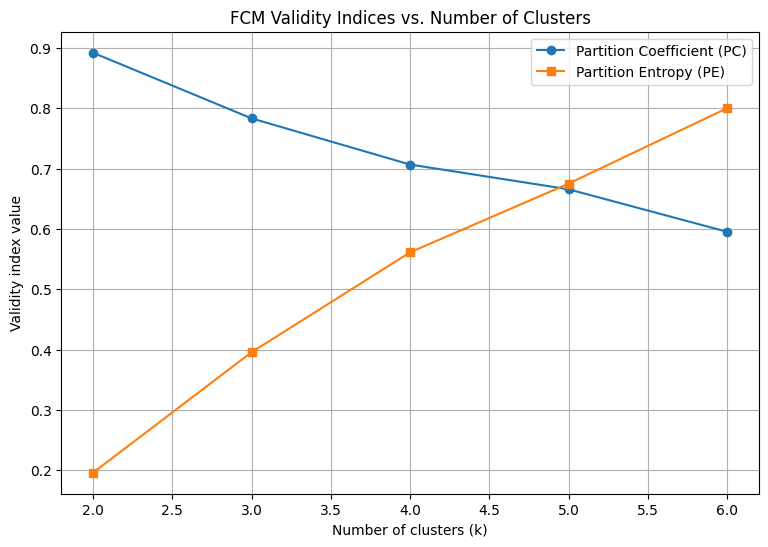

RESULTS:
Best k based on PC (highest): 2 (PC = 0.8922)
Best k based on PE (lowest): 2 (PE = 0.1957)
Both indices agree: Optimal k = 2
FCM PC and PE results on Iris


,k,PC,PE
0,2,0.892216,0.195742
1,3,0.783397,0.395492
2,4,0.706789,0.561127
3,5,0.665760,0.675145
4,6,0.595306,0.800197


In [19]:
def partition_coefficient(U):
    N = U.shape[0]
    return np.sum(U**2)/N

def partition_entropy(U):
    N = U.shape[0]
    return -np.sum(U*np.log(U))/N

data = load_iris()
X = data.data

pcs = []
pes = []
ks = list(range(2,7))

for k in ks:
    _, U, _, _ = fuzzy_c_means(X, c=k)
    pcs.append(partition_coefficient(U))
    pes.append(partition_entropy(U))

plt.figure(figsize=(9, 6))
plt.plot(ks, pcs, marker='o', label='Partition Coefficient (PC)')
plt.plot(ks, pes, marker='s', label='Partition Entropy (PE)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Validity index value')
plt.title('FCM Validity Indices vs. Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()


best_k_pc = ks[np.argmax(pcs)]
best_k_pe = ks[np.argmin(pes)]
print("RESULTS:")
print(f"Best k based on PC (highest): {best_k_pc} (PC = {max(pcs):.4f})")
print(f"Best k based on PE (lowest): {best_k_pe} (PE = {min(pes):.4f})")

# Determine overall best k
if best_k_pc == best_k_pe:
    overall_best_k = best_k_pc
    print(f"Both indices agree: Optimal k = {overall_best_k}")
else:
    print(f"Indices disagree. Consider k = {best_k_pc} or k = {best_k_pe}")

df_results = pd.DataFrame({'k': ks, 'PC': pcs, 'PE': pes})
print("FCM PC and PE results on Iris")
df_results

According to both validity indices, maximizing partition coeffcient and minimizing partition entropy, the best choice for the number of clusters on this Iris dataset is k = 2

#### Question 5

Adjusted Rand Index: 0.0147
Iterations: 10, Runtime: 0.20s


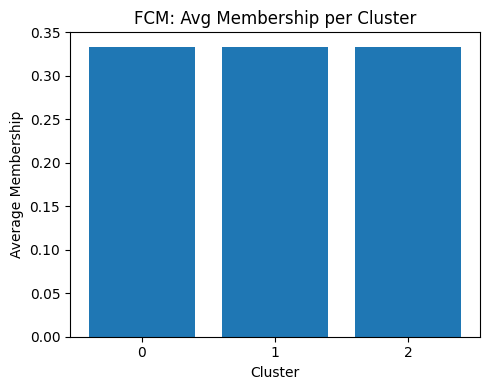

In [20]:
cats = ["rec.autos","sci.space","talk.politics.misc"]
newsg = fetch_20newsgroups(subset='all', categories=cats, remove=('headers','footers','quotes'))
docs = newsg.data[:3000]
y_true = newsg.target[:3000]

tfidf = TfidfVectorizer(max_df=0.5, min_df=2)
X_tfidf = tfidf.fit_transform(docs)
svd = TruncatedSVD(n_components=50, random_state=42)
X_red = svd.fit_transform(X_tfidf)

t0 = time.time()
V, U, iters, _ = fuzzy_c_means(X_red, c=3, m=2.0)
runtime = time.time() - t0

y_pred = U.argmax(axis=1)
ari = adjusted_rand_score(y_true, y_pred)
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Iterations: {iters}, Runtime: {runtime:.2f}s")

avg_u = U.mean(axis=0)
plt.figure(figsize=(5,4))
plt.bar(range(3), avg_u)
plt.xlabel("Cluster")
plt.ylabel("Average Membership")
plt.title("FCM: Avg Membership per Cluster")
plt.xticks(range(3))
plt.tight_layout()
plt.show()